In [6]:
#library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

In [7]:
df = pd.read_csv('bank-additional-full.csv')
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [8]:
from sklearn.model_selection import train_test_split

df.loc[(df.y == 'yes'),'y'] = 1
df.loc[(df.y == 'no'),'y']= 0
df['y'] = df['y'].astype(int)

bank_data = df.iloc[:, :-1]
bank_y = df['y'].astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(bank_data, bank_y, test_size=0.2,
                                                    random_state=7,stratify = bank_y)

In [9]:
X_train.shape

(32950, 20)

In [10]:
X_test.shape

(8238, 20)

In [11]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [ ]:
#Creating Dummies for categorical variables
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [13]:
X_train.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
8332,29,235,2,999,0,1.4,94.465,-41.8,4.864,5228.1,...,False,False,False,False,False,True,False,False,True,False
40339,31,308,1,999,2,-1.7,94.027,-38.3,0.898,4991.6,...,False,False,False,True,False,False,False,True,False,False
17592,43,398,7,999,0,1.4,93.918,-42.7,4.962,5228.1,...,False,False,False,True,False,False,False,False,True,False
11740,36,71,2,999,0,1.4,94.465,-41.8,4.959,5228.1,...,False,False,True,False,False,False,False,False,True,False
7289,58,828,3,999,0,1.1,93.994,-36.4,4.860,5191.0,...,False,False,False,False,True,False,False,False,True,False


Gradient Boosting

In [ ]:
n_estimators = [25,50,75,100,200]
max_depth = [1,3,5]

param_grid = {'n_estimators': list(n_estimators),
              'max_depth': list(max_depth)
              }
print("Parameter grid:\n{}".format(param_grid))

#Setup Grid Search
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=1,learning_rate = 0.05)
,verbose = 2, param_grid = param_grid, cv=3, return_train_score=True)
grid_search.fit(X_train, Y_train)

Parameter grid:
{'n_estimators': [25, 50, 75, 100, 200], 'max_depth': [1, 3, 5]}
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END .......................max_depth=1, n_estimators=25; total time=   0.3s
[CV] END .......................max_depth=1, n_estimators=25; total time=   0.2s
[CV] END .......................max_depth=1, n_estimators=25; total time=   0.2s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.5s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.5s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.5s
[CV] END .......................max_depth=1, n_estimators=75; total time=   0.8s
[CV] END .......................max_depth=1, n_estimators=75; total time=   0.8s
[CV] END .......................max_depth=1, n_estimators=75; total time=   0.8s
[CV] END ......................max_depth=1, n_estimators=100; total time=   1.2s
[CV] END ......................max_depth=1, n_es

GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                  random_state=1),
             param_grid={'max_depth': [1, 3, 5],
                         'n_estimators': [25, 50, 75, 100, 200]},
             return_train_score=True, verbose=2)

In [15]:
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.score)

{'max_depth': 5, 'n_estimators': 75}
0.9164188272869213
<bound method BaseSearchCV.score of GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                  random_state=1),
             param_grid={'max_depth': [1, 3, 5],
                         'n_estimators': [25, 50, 75, 100, 200]},
             return_train_score=True, verbose=2)>


In [16]:
gs_results = pd.DataFrame(grid_search.cv_results_).sort_values(by = "mean_test_score", ascending = False)

In [18]:
gs_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
12,4.096694,0.019665,0.019369,0.000488,5,75,"{'max_depth': 5, 'n_estimators': 75}",0.916060,0.917327,0.915870,0.916419,0.000647,1,0.930529,0.931443,0.932125,0.931366,0.000654
13,5.438662,0.041998,0.023695,0.000421,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.916060,0.917509,0.914413,0.915994,0.001265,2,0.933807,0.933901,0.934584,0.934097,0.000346
8,3.337667,0.038027,0.020355,0.001702,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.915331,0.916780,0.913867,0.915326,0.001189,3,0.919557,0.919652,0.920836,0.920015,0.000582
11,2.741480,0.014830,0.015611,0.000558,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.915696,0.914504,0.915142,0.915114,0.000487,4,0.927206,0.926845,0.927983,0.927344,0.000475
14,10.568738,0.025516,0.039384,0.004411,5,200,"{'max_depth': 5, 'n_estimators': 200}",0.916151,0.915779,0.913412,0.915114,0.001213,5,0.943094,0.942687,0.943779,0.943187,0.000451


In [19]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

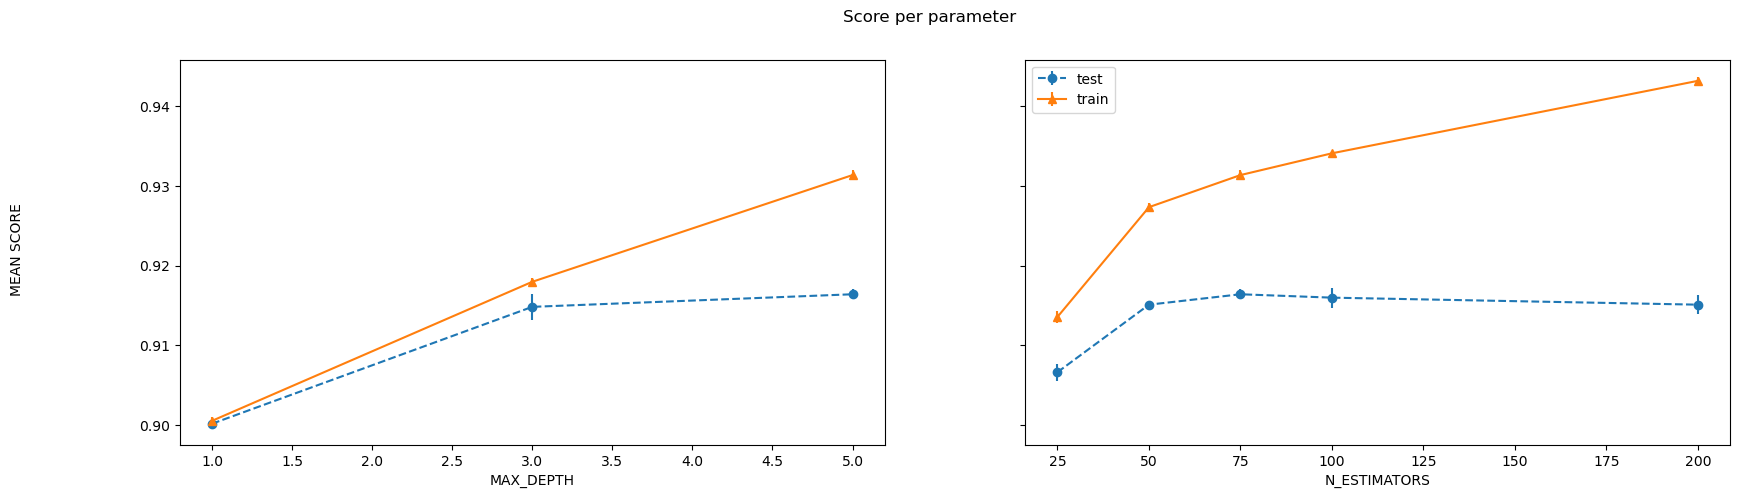

In [20]:
plot_search_results(grid_search)

In [21]:
grid_search.best_estimator_

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=75,
                           random_state=1)

In [22]:
#Train final model
classifiergb = grid_search.best_estimator_
classifiergb.fit(X_train, Y_train)

# Applying k-Fold Cross Validation
accuracies = cross_val_score(estimator = grid_search.best_estimator_, X = X_train, y = Y_train, cv = 3,n_jobs=-1)
mean_boosting=accuracies.mean()
std_boosting=accuracies.std()

In [23]:
print(mean_boosting)
print(std_boosting)

0.9164188272869213
0.0006466740906619341


<BarContainer object of 10 artists>

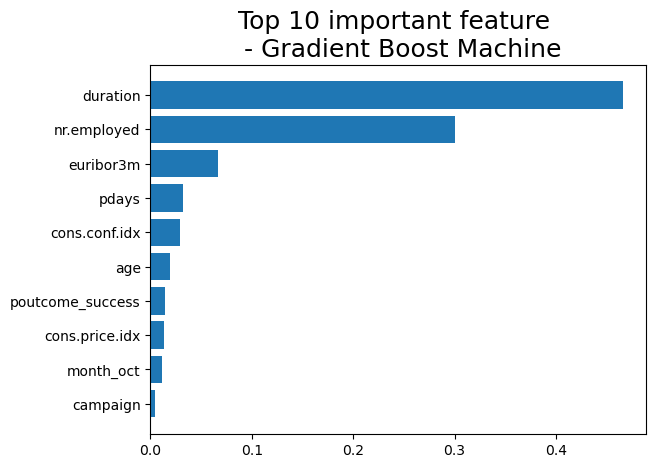

In [24]:
d = {'name':classifiergb.feature_names_in_,'importance_score':classifiergb.feature_importances_}
importance_feature = pd.DataFrame(d).sort_values(by = "importance_score", ascending = False)
importance_feature_top = importance_feature[0:10].sort_values(by = "importance_score", ascending = True)
plt.title("Top 10 important feature \n - Gradient Boost Machine", fontsize=18)
plt.barh(importance_feature_top.name,importance_feature_top.importance_score)

Test Output:
Confusion Matrix:
[[28393   845]
 [ 1548  2164]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     29238
           1       0.72      0.58      0.64      3712

    accuracy                           0.93     32950
   macro avg       0.83      0.78      0.80     32950
weighted avg       0.92      0.93      0.92     32950

Accuracy:  0.9273748103186646
Precision Score:  0.7191758059155866
Recall Score:  0.5829741379310345
(array([0.94829832, 0.71917581]), array([0.97109925, 0.58297414]), array([0.95956336, 0.64395179]), array([29238,  3712], dtype=int64))
AUC for training data is 0.9562531345751042


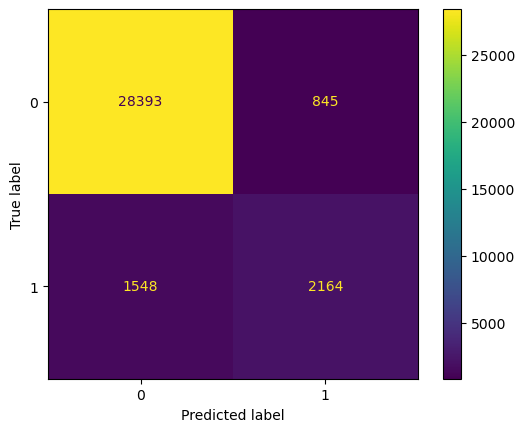

In [25]:
# Predicting the Training set results
y_predgb = classifiergb.predict(X_train)
y_predgb_score = classifiergb.predict_proba(X_train)

#Confusion Matrix
print('Test Output:')
print('Confusion Matrix:')
cm = confusion_matrix(Y_train, y_predgb)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifiergb.classes_)
disp.plot()
print('Classification Report:')
print(classification_report(Y_train, y_predgb))
print('Accuracy: ',accuracy_score(Y_train,y_predgb))

print('Precision Score: ', precision_score(Y_train, y_predgb))
print('Recall Score: ', recall_score(Y_train, y_predgb)) #482/(446+482)
print(precision_recall_fscore_support(Y_train, y_predgb))

# Gradient Boosting Classifier
grd_fpr, grd_tpr, thresold = roc_curve(Y_train, y_predgb_score[:,1])
print("AUC for training data is",auc(grd_fpr, grd_tpr))

Test Output:
Confusion Matrix:
[[7078  232]
 [ 446  482]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7310
           1       0.68      0.52      0.59       928

    accuracy                           0.92      8238
   macro avg       0.81      0.74      0.77      8238
weighted avg       0.91      0.92      0.91      8238

Accuracy:  0.9176984705025492
Precision Score:  0.6750700280112045
Recall Score:  0.5193965517241379
(array([0.94072302, 0.67507003]), array([0.96826265, 0.51939655]), array([0.95429419, 0.58708892]), array([7310,  928], dtype=int64))


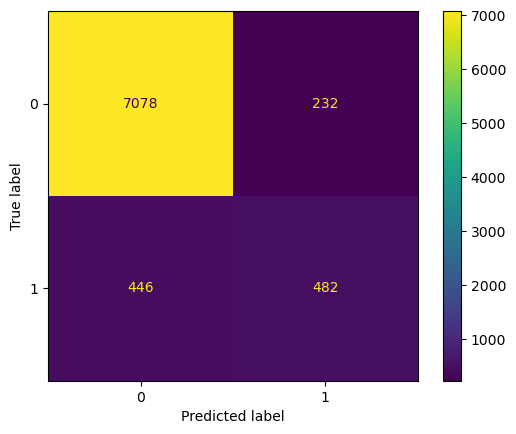

In [26]:
# Predicting the Test set results
y_predgb = classifiergb.predict(X_test)
y_predgb_score = classifiergb.predict_proba(X_test)

#Confusion Matrix
print('Test Output:')
print('Confusion Matrix:')
cm = confusion_matrix(Y_test, y_predgb)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifiergb.classes_)
disp.plot()
print('Classification Report:')
print(classification_report(Y_test, y_predgb))
print('Accuracy: ',accuracy_score(Y_test,y_predgb))

print('Precision Score: ', precision_score(Y_test, y_predgb))
print('Recall Score: ', recall_score(Y_test, y_predgb)) #482/(446+482)
print(precision_recall_fscore_support(Y_test, y_predgb))

In [27]:
# Gradient Boosting Classifier
grd_fpr, grd_tpr, thresold = roc_curve(Y_test, y_predgb_score[:,1])
print("AUC is",auc(grd_fpr, grd_tpr))

AUC is 0.9485223359592434


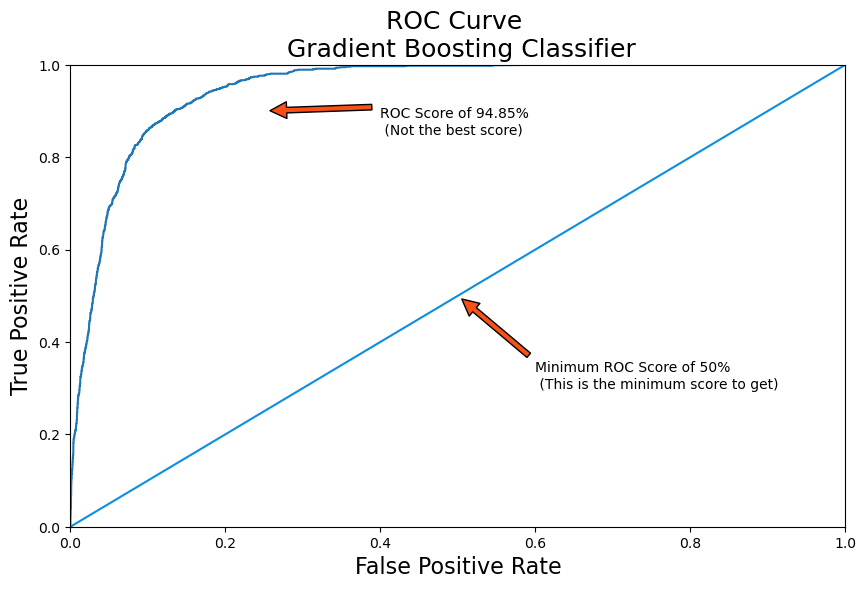

In [28]:
def graph_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.figure(figsize=(10,6))
    plt.title('ROC Curve \n Gradient Boosting Classifier', fontsize=18)
    plt.plot(false_positive_rate, true_positive_rate, label=label)
    plt.plot([0, 1], [0, 1], '#0C8EE0')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('ROC Score of {:.2%}\n (Not the best score)'.format(auc(grd_fpr, grd_tpr)), xy=(0.25, 0.9), xytext=(0.4, 0.85),
            arrowprops=dict(facecolor='#F75118', shrink=0.05),
            )
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#F75118', shrink=0.05),
                )
graph_roc_curve(grd_fpr, grd_tpr)
plt.show()